# Assignment 3

### Kamil Tokarski kt361223


First some definitions that will come in handy when working in colab



In [1]:
import random

import pandas

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.rnn as rnn

from torch.utils import data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

import numpy as np

from google.colab import drive



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
drive.mount("/content/gdrive")

WORKING_DIR = "/content/gdrive/My Drive/colab/assigment 3/"
DATA_DIR = WORKING_DIR + "data/"

IMGS_DIR = WORKING_DIR + "imgs/"

DATA_TEST_X = DATA_DIR + "test_x.csv"
DATA_TEST_Y = DATA_DIR + "test_y.csv"
DATA_TRAIN_X = DATA_DIR + "train_x.csv"
DATA_TRAIN_Y = DATA_DIR + "train_y.csv"

# !unzip "{WORKING_DIR + "DL1920-assignment3-data.zip"}" -d "{WORKING_DIR + "data"}"

!ls -la "{DATA_DIR}"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 216
-rw------- 1 root root  20000 May 13 19:44 test_x.csv
-rw------- 1 root root   2000 May 13 19:44 test_y.csv
-rw------- 1 root root 180000 May 13 19:44 train_x.csv
-rw------- 1 root root  18000 May 13 19:44 train_y.csv


In [3]:
!head "{DATA_TEST_X}"
!head "{DATA_TEST_Y}"

3-8,4-7,5-6,6-7,7-6
1-2,0-3,1-4,2-3,1-4
5-7,4-6,3-5,2-6,1-7
1-8,2-9,3-8,2-9,1-8
1-9,0-8,1-9,0-8,1-9
4-8,5-7,4-6,3-5,4-4
5-4,6-3,7-4,6-3,5-2
6-2,5-3,4-4,3-5,2-6
8-0,7-1,6-0,7-1,6-2
3-4,4-3,5-4,6-5,7-4
2
0
1
0
1
3
3
1
3
0


In [0]:
def parse_x(filename):
  csv = pandas.read_csv(filename, header=None,)
  csv = csv.apply(lambda c: c.str.split('-', expand=True).astype(int), axis=1)
  return torch.stack([torch.as_tensor(s.values) for s in csv])

def parse_y(filename):
  tensor = torch.tensor(pandas.read_csv(filename, header=None,).values)
  return tensor.reshape(tensor.shape[0:1])


In [5]:
train_x = parse_x(DATA_TRAIN_X)
train_y = parse_y(DATA_TRAIN_Y)
test_x = parse_x(DATA_TEST_X)
test_y = parse_y(DATA_TEST_Y)

print([tens.shape for tens in [train_x, train_y, test_x, test_y]])

[torch.Size([9000, 5, 2]), torch.Size([9000]), torch.Size([1000, 5, 2]), torch.Size([1000])]


In [0]:
def x_stats(x):
  plane = x.view([-1, 2])

  print(plane.min(dim=0), plane.max(dim=0))

  plt.figure() 
  plt.hist(plane[:, 0].numpy())
  plt.hist(plane[:, 1].numpy(), alpha=0.5)


def y_stats(y):
  plt.figure()
  plt.hist(y.numpy())

## Dataset

Firstly let's make some sanity checks on data to makes sure there's no need to dread of class imabalnce or some striking outliers

torch.return_types.min(
values=tensor([0, 0]),
indices=tensor([44999, 44995])) torch.return_types.max(
values=tensor([9, 9]),
indices=tensor([44973, 44989]))
torch.return_types.min(
values=tensor([0, 0]),
indices=tensor([4993, 4995])) torch.return_types.max(
values=tensor([9, 9]),
indices=tensor([4955, 4993]))


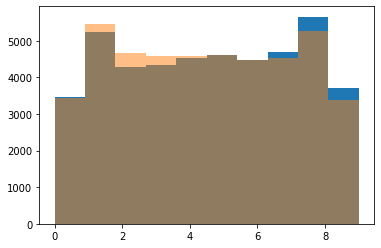

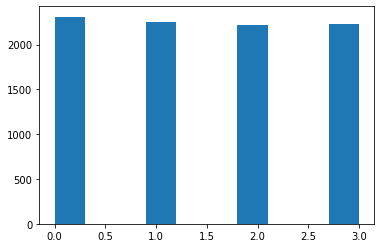

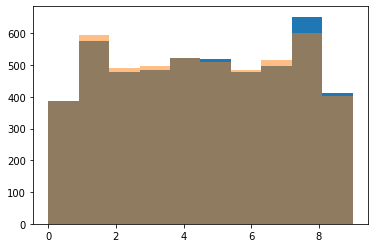

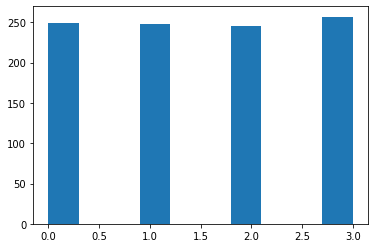

In [7]:
x_stats(train_x)
y_stats(train_y)
x_stats(test_x)
y_stats(test_y)

In [0]:

def plot_movement(samples, start_dot=50, dot_step=100, lim_x=None, lim_y=None):
  m = len(samples)
  fig, axs = plt.subplots(1, m, sharex=True, sharey=True, figsize=(4 * m, 4))
  axes = plt.gca()
  plt.subplots_adjust(wspace=0)
  axes.set_xlim(lim_x or [-1,10])
  axes.set_ylim(lim_y or [-1,10])
  for i in range(m):
    sample = samples[i]
    n = len(sample)
    c_space = cm.winter(np.linspace(0, 1, n))
    s_space = np.linspace(start_dot, 50 + dot_step * n, n)
    x1s = sample[:, 0]
    x2s = sample[:, 1]
    axs[i].scatter(x1s, x2s, color=c_space, s=s_space, alpha=0.3)
    axs[i].plot(x1s, x2s)

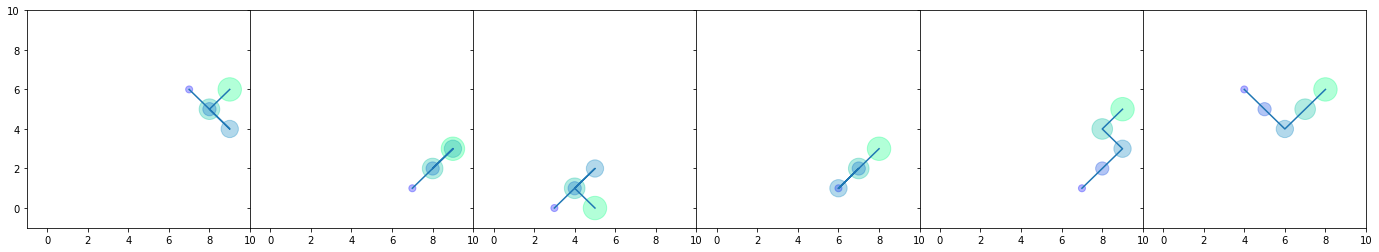

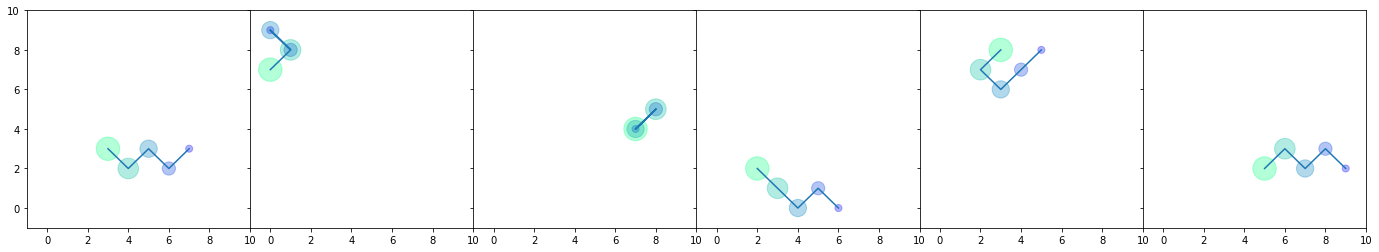

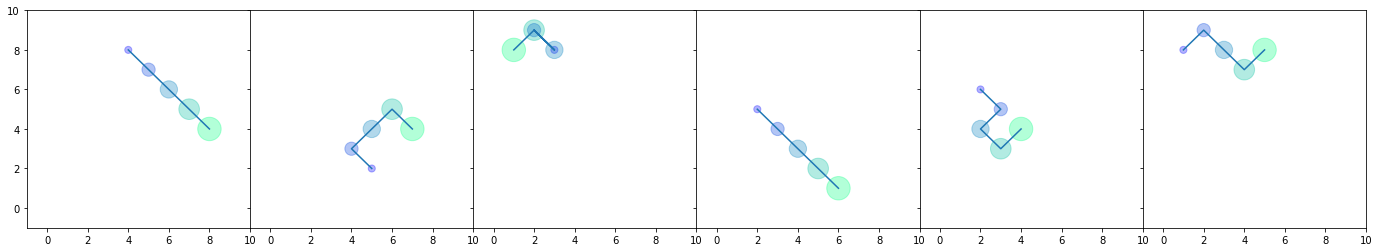

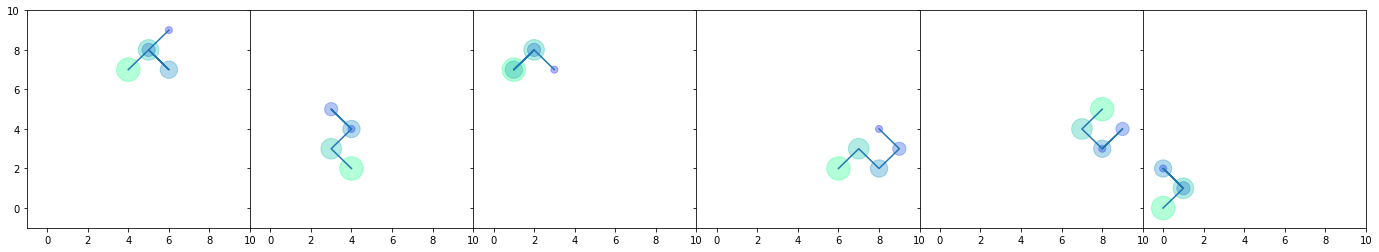

In [9]:
for i in range(4):
  plot_movement(train_x[train_y == i][:6])


# Visualization

I am using increasing size of a dot and color shift from blue to green to visualize change over time.

To be completely frank I had no clue as to what might be a difference between them. I only get some idea after training the first model that achieved over 65% accuracy and looking at succesfully classified samples (this is presented later on as well).

One idea is that those are particles attracted by some charge to one of the four corners of the grid (where class tells what corner is that, respectively: top-right, top-left, bottom-right and bottom-left). Additionally there is probability below 1/2 that at any given state particle will divarge in different direction. Such a process would result in a number of samples where direction is really difficult to tell by looking at the sequence of 5 moves. And that is the case in the given dataset - such examples are present below as well and are strewn between classes which makes distingusing between classes hard.


There are 6 examples per class displayed here (row by row).

# Model

Model is straigthforawd, cosists of lstm layer followed by danse layer (which probalby could be smaller but works fine).

Input to the network must be padded with zeros to the maximal length of 5 in any given obesrvation. Actual length need to be provided along the batch to the network. If all the samples length is 5 lengths argument can be ommited.

In [0]:
PADD_VALUE = -1


class Net(nn.Module):

  def __init__(self, h_size=64, classes_no=4):

    super().__init__()

    self.lstm = nn.LSTM(2, h_size, batch_first=True)
    self.dense = nn.Sequential(
      nn.Linear(h_size, 32),
      nn.BatchNorm1d(32),
      nn.ReLU(),
      nn.Linear(32, 16),
      nn.BatchNorm1d(16),
      nn.ReLU(),
      nn.Linear(16, classes_no),
      nn.ReLU(),
    )
    self.h_size = h_size

  def forward(self, x, lens=None):
    lens = lens if lens is not None else torch.tensor(([5] * len(x))).to(device)
    x = rnn.pack_padded_sequence(x, lens, batch_first=True, enforce_sorted=False)
    _, (ht, _) = self.lstm(x)
    return self.dense(ht.reshape([-1, self.h_size]))


In [0]:
BATCH_SIZE = 3000


class TruncutedDataSet(torch.utils.data.Dataset):

  def __init__(self, xs, ys, lengths):
    assert(len(xs) > 0)
    m = len(xs[0])
    self.lengths = lengths
    x_trunc = [x[0:n] for x, n in zip(xs, self.lengths)]
    x_trunc = rnn.pad_sequence(x_trunc, batch_first=True, padding_value=PADD_VALUE)
    super().__init__()
    self.xs = x_trunc
    self.ys = ys
  
  def __len__(self):
    return len(self.xs)
  
  def __getitem__(self, idx):
    return self.xs[idx], self.ys[idx], self.lengths[idx]
  
  @classmethod
  def create_loader(cls, xs, ys, lengths, batch_size=BATCH_SIZE, shuffle=True):
    dataset = cls(xs.float(), ys, lengths)
    loader = data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle,
    )
    return dataset, loader


Dataset that truncates provided sequences according to the lengths argument.

In [0]:
class EvalNet(object):
    
    def __init__(self, net):
        self.net = net
        
    def __enter__(self):
        self.net.eval()
        torch.set_grad_enabled(False)
        return self.net
    
    def __exit__(self, type, value, traceback):
        torch.set_grad_enabled(True)
        self.net.train()  


def test_net(net, xs=test_x, ys=test_y, epoch=None):
    correct = 0
    total = 0

    with EvalNet(net):
      outputs = net(xs.float().to(device))
      _, predicted = torch.max(outputs.data, 1)
      total += ys.size(0)
      correct += (predicted == ys.to(device)).sum().item()
    return correct, total


In [0]:
MODEL_SAVE_PATH = WORKING_DIR + "training/{}{}.pth"
LOOP_STATS = 10
EPOCHS_NO = 300


def variadic_loop(train_loader, optimizer, net, loss_fun):
  running_loss = 0.
  for i, (xs, ys, lens) in enumerate(train_loader, 0):
      lens = lens.to(device)
      xs = xs.to(device)
      ys = ys.to(device)
      
      optimizer.zero_grad()
      outputs = net(xs, lens)
      
      loss = loss_fun(outputs, ys)            
      loss.backward()
      
      optimizer.step()

      running_loss += loss.item()
  return running_loss



def train(net, name, loss_fun, optimizer, train_loader, loop, test_info=None, resume_epoch=0, epochs_no=EPOCHS_NO):

    if resume_epoch > 0:
        net.load_state_dict(torch.load(
            MODEL_SAVE_PATH.format(name, resume_epoch - 1), map_location=device
        ))
    
    j = 0
    for epoch in range(resume_epoch, epochs_no):  # loop over the dataset multiple times
        
        running_loss = loop(train_loader, optimizer, net, loss_fun)
            
        if test_info is not None:
          print(test_info(net, epoch=epoch))
        print('[%d] loss: %.3f' % (
            epoch,
            running_loss / (len(loader.dataset) / loader.batch_size)
        ))
        if epoch % 50 == 0 or epoch == epochs_no - 1:
          torch.save(net.state_dict(), MODEL_SAVE_PATH.format(name, epoch))

    print('Finished Training')

This is the part with training on dataset with some sequences truncated to the length of 4 to prove it works.

In [14]:
net = Net()
net = net.to(device)

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-2)

lengths = random.choices([4, 5], k=len(train_x))
_, loader = TruncutedDataSet.create_loader(train_x, train_y, lengths)

train(net, 'variadic', loss_fun, optimizer, loader, variadic_loop, test_net, resume_epoch=0, epochs_no=1)

(257, 1000)
[0] loss: 1.371
Finished Training


And here is the full training of model on the original dataset. It achieves around 67-68% accuracy.

In [43]:
net = Net()
net = net.to(device)

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-2)


lengths = [5] * len(train_x)
_, loader = TruncutedDataSet.create_loader(train_x, train_y, lengths)

train(net, 'net_', loss_fun, optimizer, loader, variadic_loop, test_net, resume_epoch=0, epochs_no=50)

(257, 1000)
[0] loss: 1.374
(257, 1000)
[1] loss: 1.307
(257, 1000)
[2] loss: 1.283
(257, 1000)
[3] loss: 1.262
(257, 1000)
[4] loss: 1.243
(276, 1000)
[5] loss: 1.224
(370, 1000)
[6] loss: 1.206
(424, 1000)
[7] loss: 1.189
(441, 1000)
[8] loss: 1.173
(440, 1000)
[9] loss: 1.157
(402, 1000)
[10] loss: 1.140
(377, 1000)
[11] loss: 1.124
(401, 1000)
[12] loss: 1.112
(460, 1000)
[13] loss: 1.103
(496, 1000)
[14] loss: 1.091
(488, 1000)
[15] loss: 1.082
(498, 1000)
[16] loss: 1.073
(498, 1000)
[17] loss: 1.065
(507, 1000)
[18] loss: 1.056
(527, 1000)
[19] loss: 1.051
(512, 1000)
[20] loss: 1.044
(523, 1000)
[21] loss: 1.037
(516, 1000)
[22] loss: 1.031
(516, 1000)
[23] loss: 1.026
(522, 1000)
[24] loss: 1.021
(494, 1000)
[25] loss: 1.016
(532, 1000)
[26] loss: 1.011
(512, 1000)
[27] loss: 1.007
(549, 1000)
[28] loss: 1.003
(533, 1000)
[29] loss: 1.000
(538, 1000)
[30] loss: 0.997
(545, 1000)
[31] loss: 0.993
(532, 1000)
[32] loss: 0.990
(558, 1000)
[33] loss: 0.988
(554, 1000)
[34] loss: 0

In [16]:
import seaborn as sn
import pandas as pd

def confusion(net, xs, ys, **extra):
    css = torch.zeros(4, 4)
    with EvalNet(net):
        xs, ys = xs.float().to(device), ys.to(device)
        outputs = net(xs, **extra)
        _, predicted = torch.max(outputs.data, 1)
        for p, l in zip(predicted, ys):
            css[p, l] += 1
    return css

def draw_conf_matrix(cm, vmax=None):
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    df_cm = pd.DataFrame(cm.numpy(), range(4), range(4))
    plt.figure(figsize=(7,6))
    sn.set(font_scale=0.9) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}, fmt='g', vmax=vmax) # font size
    plt.show()


def stats(cm):
    tp_and_fp = torch.sum(cm, 1)
    p = torch.sum(cm, 0) # tp and fn
    tp = torch.tensor([cm[i, i] for i in range(cm.shape[0])])
    tpr = torch.div(tp, p) # sesnitivity (tpr) how many of the images of given actor has been properly labelled
    prec = torch.div(tp, tp_and_fp) # precision - how credibile is model saying that this is a given actor
    return [v.reshape((1, -1)) for v in [tpr, prec]]



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Here you can see consufion matrix together with recall (blue) and precision (orange).

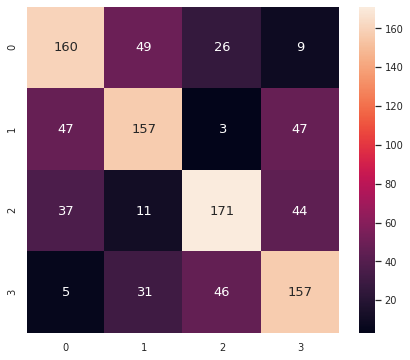

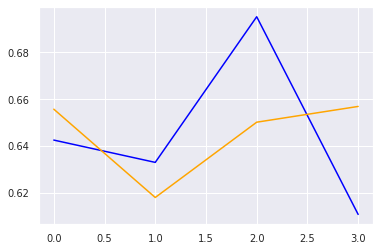

In [17]:
def print_confusion_stats():
  cm = confusion(net, test_x, test_y)
  draw_conf_matrix(cm)
  sts = torch.cat(stats(cm), 0)
  plt.plot(sts[0], color='blue')
  plt.plot(sts[1], color='orange')

print_confusion_stats()

In [0]:
def plot_successful(i):
  with EvalNet(net):
    klass_x = test_x[test_y == i].float()
    outputs = net(klass_x.to(device))
    _, predicted = torch.max(outputs.data, 1)
    for j in range(2):
      plot_movement(klass_x[predicted == i][6 * j:6 * (j + 1)])


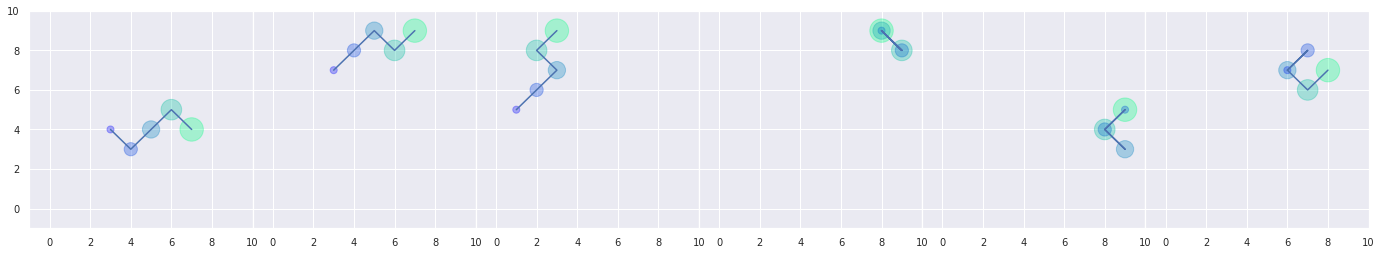

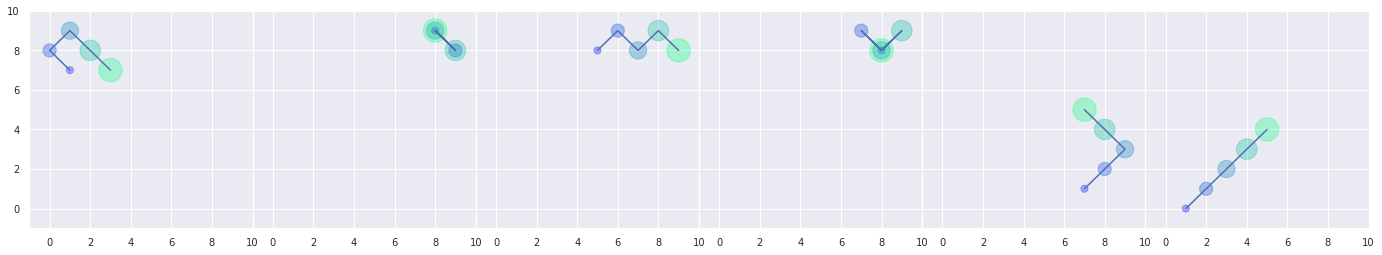

In [19]:
plot_successful(0)

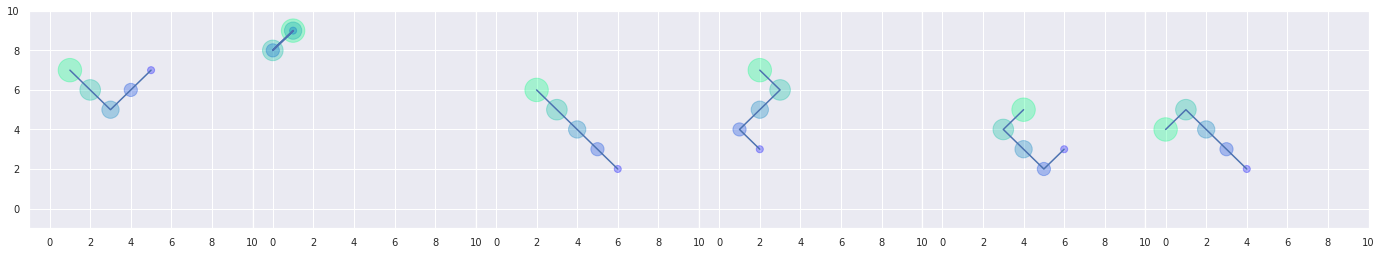

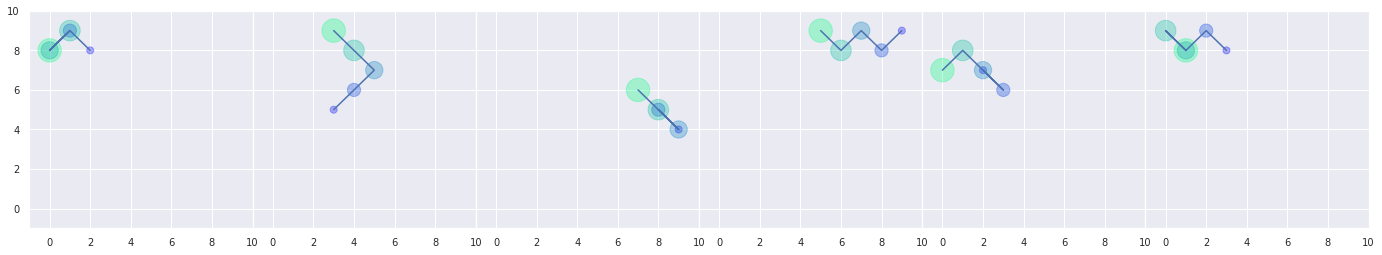

In [20]:
plot_successful(1)

Ok, this is a part that helped me to formulate the hypothesis about the difference between classes. These are plots similar to the ones above but only for successfuly classified examples.

There are 12 examples per class displayed here (two consecutive rows per class)

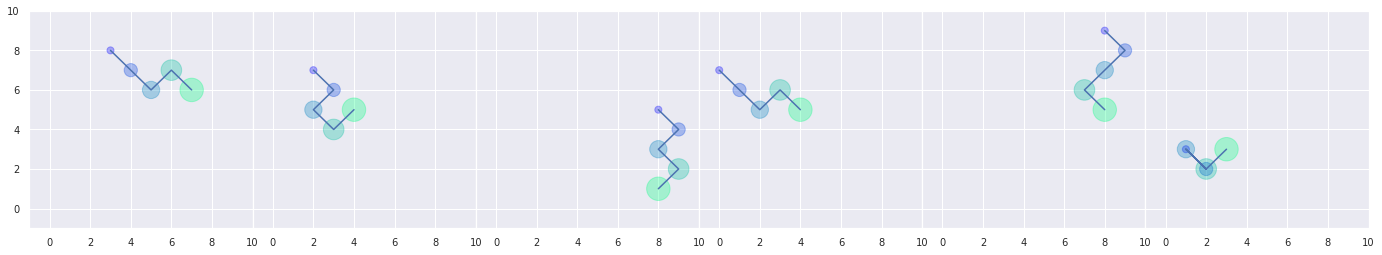

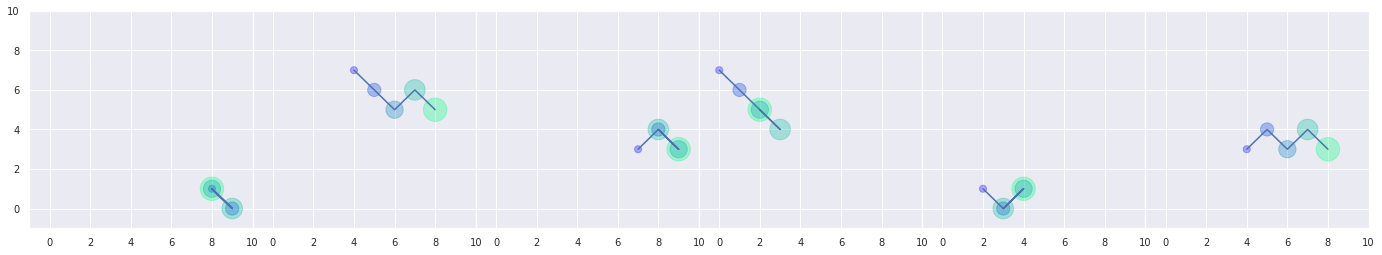

In [21]:
plot_successful(2)

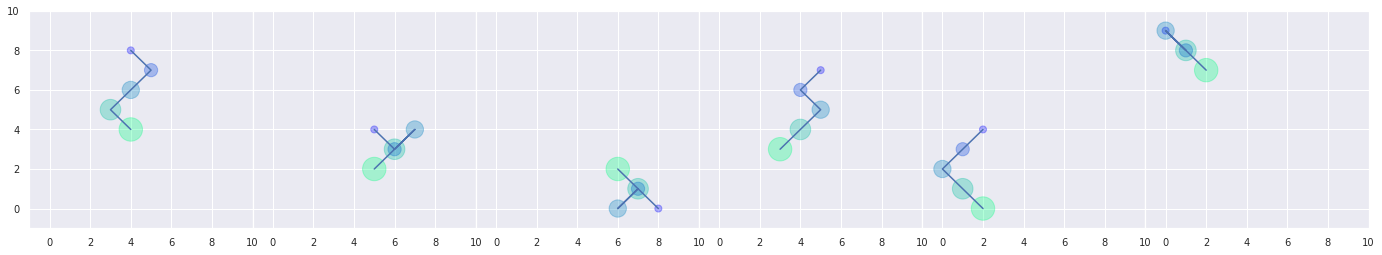

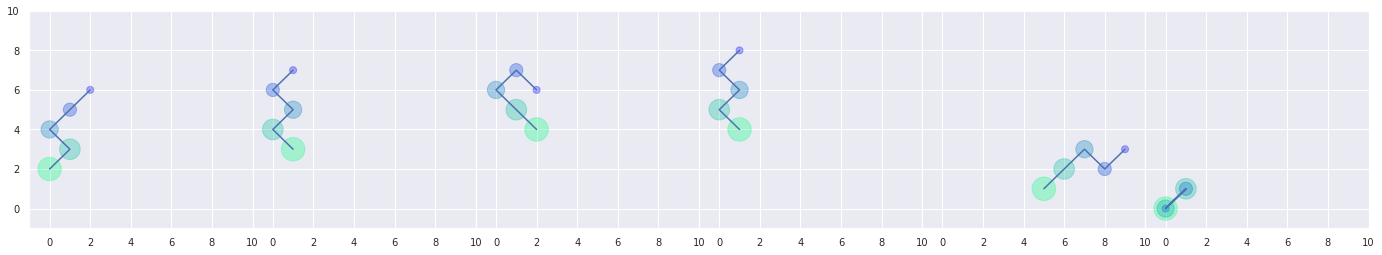

In [22]:
plot_successful(3)

In [0]:
def random_map():
  pi = list(range(100))
  random.shuffle(pi)
  grid = [(x, y) for x in range(10) for y in range(10)]
  return dict(zip(grid, pi))


mapping = random_map()


def embedWithMapping(xs, mapping=mapping):
  return torch.stack([
    torch.tensor([
      mapping[tuple(x.item() for x in xt)] for xt in ts
    ]) for ts in xs
  ])


e_train_x = embedWithMapping(train_x).float()
e_test_x = embedWithMapping(test_x).float()

# Embedding

In the following cells each grid cell (there are 100 of them) is asociated with a number from random permutation of (0..100). Next the above model with embedding layer added at the beggining is trianed on such modified dataset.

Embedding is not linear (it performed poorly) and each grid-number is explictly one-hot encoded at the input of the net. Models without explict one-hot encoding achived accuracy around 55%, whereas model fed with one-hot encoded data easily gains accuracy over 65%. I tried to create a layer with softmax that could hopefully act as a replacement of one-hot encoding but to no avail.

In [0]:
class Embedder(nn.Module):
  
  def __init__(self):
    super().__init__()

    self.onehot = torch.eye(100).float().to(device)
    self.r = nn.Sequential(
        nn.Linear(100, 100, bias=False),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Linear(100, 2),
    )

  def forward(self, x):
    x = self.onehot[x.long()]
    x = x.reshape([-1, 100])
    return self.r(x)


class EmbNet(nn.Module):

  def __init__(self):

    super().__init__()
    
    self.embedder = Embedder()
    self.lstm_net = Net()

  def forward(self, xs, with_embed=True):
    xs = xs.reshape([-1, 1])
    xs = self.embedder(xs)
    xs_emb = xs.reshape([-1, 5, 2])
    lens = torch.tensor([5] * len(xs_emb))
    xs = self.lstm_net(xs_emb, lens)
    if not with_embed:
      return xs
    return xs, xs_emb

emb_net = EmbNet()

In [0]:
def loop(train_loader, optimizer, net, loss_fun):
  running_loss = 0.
  for i, (xs, ys) in enumerate(train_loader, 0):
      xs = xs.to(device)
      ys = ys.to(device)
      
      optimizer.zero_grad()
      outputs, _ = net(xs)
      
      loss = loss_fun(outputs, ys)            
      loss.backward()
      
      optimizer.step()

      running_loss += loss.item()
  return running_loss


def create_e_loader(xs, ys, batch_size=BATCH_SIZE, shuffle=True):
    dataset = data.TensorDataset(xs.float(), ys)
    loader = data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle,
    )
    return dataset, loader


In [0]:
def plot_grid(samples, start_dot=50, dot_step=10):
  fig = plt.figure()
  axes = plt.gca()
  plt.subplots_adjust(wspace=0)
  mns = samples.min()
  mxs = samples.max()
  axes.set_xlim([mns - 1, mxs + 1])
  axes.set_ylim([mns - 1, mxs + 1])
  fig.set_figheight(8)
  fig.set_figwidth(8)
  n = len(samples)
  c_space = cm.winter(np.linspace(0, 1, n))
  s_space = np.linspace(start_dot, 50 + dot_step * n, n)
  s_space = torch.stack([
    torch.tensor(s_space[10 * i: 10 * (i + 1)]) for i in range(10)
  ]).T
  s_space = [s.item() for ss in s_space for s in ss]
  x1s = samples[:, 0]
  x2s = samples[:, 1]
  plt.scatter(x1s, x2s, color=c_space, s=s_space, alpha=0.3)
  for i in range(10):
    plt.plot(
      x1s[10 * i : 10 * (i + 1)],
      x2s[10 * i : 10 * (i + 1)],
      color=c_space[10 * i],
    )
    for j in range(9):
    # hor_indxs = [k.item() for k in 10 * torch.tensor(range(10)) + i]
      inds = 10 * (torch.tensor(range(2)) + j) + i
      # ind = 10 * j + i
      plt.plot(
          x1s[inds],
          x2s[inds],
          color=c_space[inds[0]],
      )
  return fig


grid = torch.tensor([[i, j] for i in range(10) for j in range(10)])


def embed_grid(net):
  batched_grid = embedWithMapping(torch.stack([
    grid[5 * i: 5 * (i + 1)] for i in range(20)
  ]))
  with EvalNet(net):
    _, emb_grid = net(batched_grid.float().to(device))
    emb_grid = emb_grid.cpu().reshape([100, 2])
    return plot_grid(emb_grid)


def e_test_net(net, xs=e_test_x, ys=test_y, epoch=None):
    correct = 0
    total = 0

    with EvalNet(net):
      outputs, _ = net(xs.float().to(device))
      _, predicted = torch.max(outputs.data, 1)
      total += ys.size(0)
      correct += (predicted == ys.to(device)).sum().item()
    
    fig = embed_grid(net)
    plt.savefig(IMGS_DIR + 'grid{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
    plt.close(fig)

    return correct, total

In [27]:
emb_net = EmbNet()
emb_net = emb_net.to(device)

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.Adam(emb_net.parameters(), lr=0.01, weight_decay=0.001)


_, loader = create_e_loader(e_train_x, train_y,)

train(emb_net, 'emb_net_', loss_fun, optimizer, loader, loop, e_test_net, resume_epoch=0, epochs_no=60,)

(246, 1000)
[0] loss: 1.397
(246, 1000)
[1] loss: 1.324
(249, 1000)
[2] loss: 1.268
(249, 1000)
[3] loss: 1.215
(249, 1000)
[4] loss: 1.159
(252, 1000)
[5] loss: 1.111
(386, 1000)
[6] loss: 1.074
(341, 1000)
[7] loss: 1.050
(374, 1000)
[8] loss: 1.023
(334, 1000)
[9] loss: 1.002
(428, 1000)
[10] loss: 0.989
(451, 1000)
[11] loss: 0.975
(463, 1000)
[12] loss: 0.968
(514, 1000)
[13] loss: 0.958
(506, 1000)
[14] loss: 0.951
(543, 1000)
[15] loss: 0.946
(531, 1000)
[16] loss: 0.940
(566, 1000)
[17] loss: 0.943
(557, 1000)
[18] loss: 0.935
(547, 1000)
[19] loss: 0.936
(556, 1000)
[20] loss: 0.933
(563, 1000)
[21] loss: 0.930
(560, 1000)
[22] loss: 0.928
(568, 1000)
[23] loss: 0.929
(566, 1000)
[24] loss: 0.928
(557, 1000)
[25] loss: 0.929
(561, 1000)
[26] loss: 0.927
(613, 1000)
[27] loss: 0.928
(673, 1000)
[28] loss: 0.917
(678, 1000)
[29] loss: 0.881
(676, 1000)
[30] loss: 0.826
(685, 1000)
[31] loss: 0.780
(675, 1000)
[32] loss: 0.761
(677, 1000)
[33] loss: 0.751
(685, 1000)
[34] loss: 0

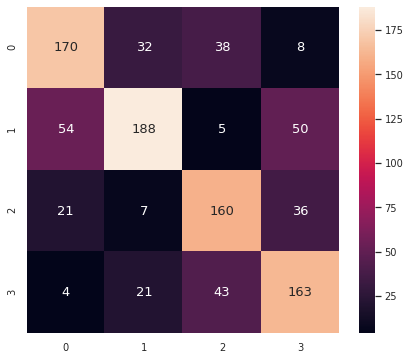

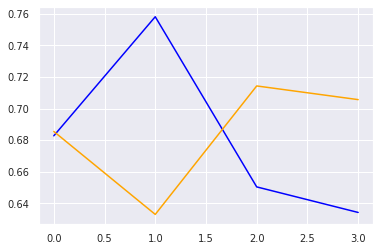

In [28]:
def print_confusion_stats():
  cm = confusion(emb_net, e_test_x, test_y, with_embed=False)
  draw_conf_matrix(cm)
  sts = torch.cat(stats(cm), 0)
  plt.plot(sts[0], color='blue')
  plt.plot(sts[1], color='orange')

print_confusion_stats()

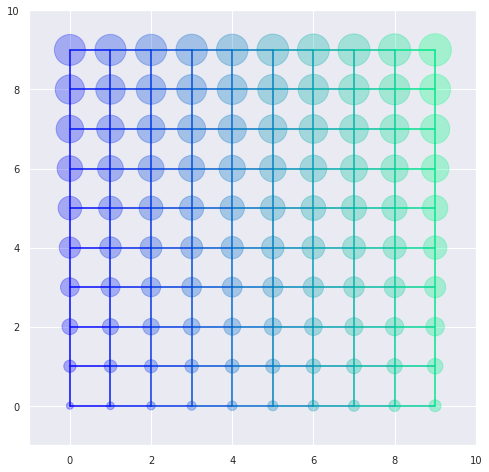

In [29]:
plot_grid(grid)
pass

Here I present how points from the original grid are displaced in the embedded version. You can see 1. original grid, 2. its embedding and 3. the animation of the training process where at the begining all the space is squeezed to a single point.

Meaning of colours and dot size is slightly different from the sequences case - here dots are bigger in ys and color changes in xs direction.

Embedding is clearly not a linear transformation of the original space however some sense of distance is preserved here. One could argue they even form some sort of clusters corresponding to typical placing of samples from classes.

I.e. on orginal grid samples from classes 0..3 are more likely to be found in the - respecitvely: top right corner, top left corner, bottom right and botton left corner. This kind of space *clustering* is visible in the embedded space (modulo horizontal flip).

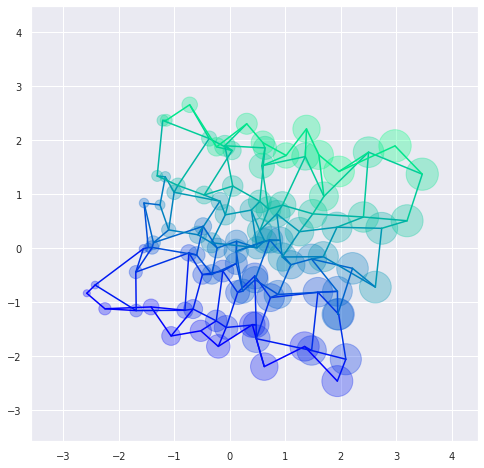

In [30]:
embed_grid(emb_net)
pass

In [31]:
for i in range(4):
  print(train_x[train_y == i].float().mean((0, 1)),)


print(train_x.float().mean((0, 1)))

tensor([5.4499, 5.2029])
tensor([3.7277, 5.2062])
tensor([5.3711, 3.7265])
tensor([3.7711, 3.7045])
tensor([4.5849, 4.4701])


![alt text](https://drive.google.com/uc?export=view&id=1WrMxADH8HmdFfiaxhbXUG-NtPt5J22Zd)

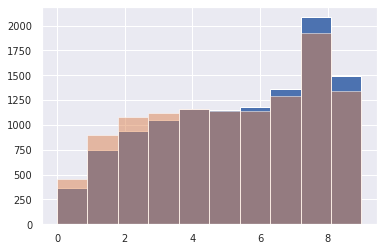

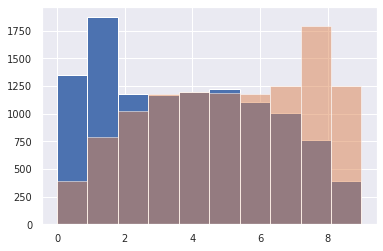

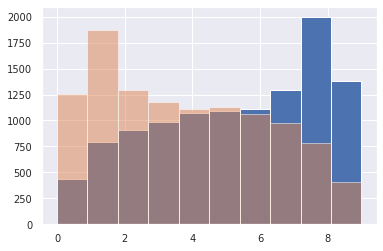

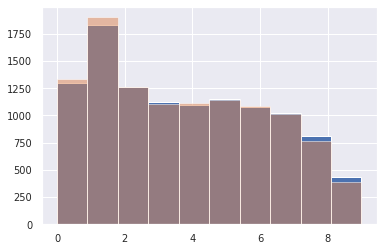

In [32]:
for i in range(4):
  plt.figure()
  plt.hist(train_x[train_y == i].float().reshape([-1, 2])[:, 0])
  plt.hist(train_x[train_y == i].float().reshape([-1, 2])[:, 1], alpha=0.5)

In [0]:
def plot_tracks(samples, ax=None, alpha=None):
  for sample in samples:
    n = len(sample)
    c_space = cm.winter(np.linspace(0, 1, n))
    x1s = sample[:, 0]
    x2s = sample[:, 1]
    ax.plot(x1s, x2s, alpha=alpha, color='red')


def plot_per_class(plot_fun, groups, lim_x=None, lim_y=None, alpha=0.005):
  n = len(groups)
  fig, axs = plt.subplots(1, n, sharex=True, sharey=True, figsize=(4 * n, 4))
  axes = plt.gca()
  plt.subplots_adjust(wspace=0)
  if lim_x is not None:
    axes.set_xlim(lim_x)
  if lim_y is not None:
    axes.set_ylim(lim_y)
  for group, ax in zip(groups, axs):
    plot_fun(group, ax, alpha)



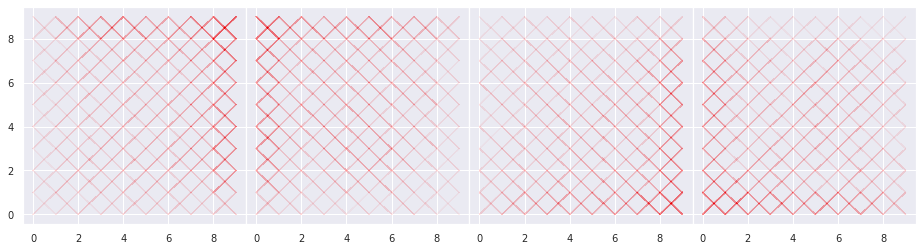

In [42]:
plot_per_class(plot_tracks, [train_x[train_y == i] for i in range(4)])

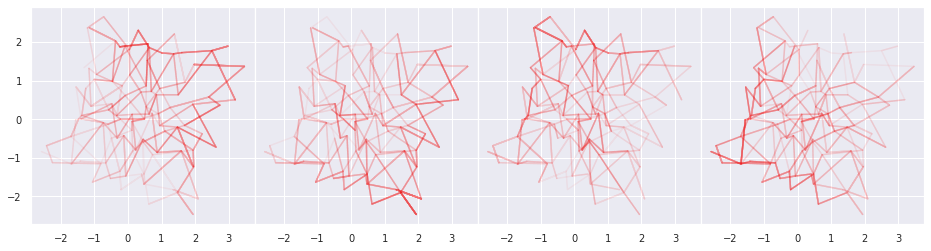

In [41]:
def plot_embedded_tracks():
  with EvalNet(emb_net):
    klasses_x = [test_x[test_y == i].float() for i in range(4)]
    e_klasses_x = [
      embedWithMapping(klass_x).float().to(device)
      for klass_x in klasses_x
    ]
    embss = [emb_net(ekl)[1].cpu() for ekl in e_klasses_x]
    plot_per_class(plot_tracks, embss, alpha=0.05)

plot_embedded_tracks()